In [1]:
import pandas as pd
from preprocessing import preprocessor

In [2]:
df = pd.read_csv("D:/cdac/CDAC_PROJECT/Untitled Folder/Training_Batch_Files/visibility_08012008_120010.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6257 entries, 0 to 6256
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DATE              6257 non-null   object 
 1   VISIBILITY        6257 non-null   float64
 2   DRYBULBTEMPF      6257 non-null   int64  
 3   WETBULBTEMPF      6257 non-null   int64  
 4   DewPointTempF     6257 non-null   int64  
 5   RelativeHumidity  6257 non-null   int64  
 6   WindSpeed         6257 non-null   int64  
 7   WindDirection     6257 non-null   int64  
 8   StationPressure   6257 non-null   float64
 9   SeaLevelPressure  6257 non-null   float64
 10  Precip            6257 non-null   float64
dtypes: float64(4), int64(6), object(1)
memory usage: 537.8+ KB


In [4]:
df.shape

(6257, 11)

In [5]:
df.isnull().sum()

DATE                0
VISIBILITY          0
DRYBULBTEMPF        0
WETBULBTEMPF        0
DewPointTempF       0
RelativeHumidity    0
WindSpeed           0
WindDirection       0
StationPressure     0
SeaLevelPressure    0
Precip              0
dtype: int64

In [6]:
df = df.drop(['DATE'],axis=1)
df.shape

(6257, 10)

In [7]:
new_df = df.drop(['Precip','WETBULBTEMPF','DewPointTempF','StationPressure'],axis=1)
new_df.shape

(6257, 6)

## split X and Y

In [8]:
X = new_df.drop(['VISIBILITY'],axis=1)
Y = new_df['VISIBILITY']

In [9]:
X.shape,Y.shape

((6257, 5), (6257,))

In [10]:
X.columns

Index(['DRYBULBTEMPF', 'RelativeHumidity', 'WindSpeed', 'WindDirection',
       'SeaLevelPressure'],
      dtype='object')

In [11]:
Y.head(10)

0    6.00
1    6.00
2    5.00
3    5.00
4    5.00
5    5.00
6    4.00
7    1.25
8    2.50
9    2.50
Name: VISIBILITY, dtype: float64

## TRAIN TEST SPLIT

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.3, random_state=7)
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((4379, 5), (1878, 5), (4379,), (1878,))

## RANDOM FOREST

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rf= RandomForestRegressor()

In [26]:
param_grid = {"n_estimators": [50, 100, 130],
              "criterion": ['squared_error', 'absolute_error', 'poisson'],
              "max_depth": range(2, 4, 1), 
              "max_features": ['sqrt', 'log2']
             }

In [27]:
gscv =GridSearchCV(estimator = rf, param_grid = param_grid, cv=5)

In [28]:
gscv.fit(X_train,Y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'poisson'],
                         'max_depth': range(2, 4),
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 100, 130]})

In [29]:
gscv.best_params_

{'criterion': 'squared_error',
 'max_depth': 3,
 'max_features': 'log2',
 'n_estimators': 50}

In [30]:
rf = RandomForestRegressor(n_estimators=50,max_depth=3, max_features='log2',criterion='squared_error',random_state=7)
rf.fit(X_train,Y_train)

RandomForestRegressor(max_depth=3, max_features='log2', n_estimators=50,
                      random_state=7)

In [31]:
Y_pred_rf = rf.predict(X_test)

## Apply XGBoost

In [32]:
from sklearn.ensemble import GradientBoostingRegressor

In [33]:
param_grid = {
'n_estimators' : [ 50, 200],
'subsample' : [0.7, 0.8],
'max_depth' :[ 5,7],
'learning_rate': [0.5, 0.01]
}

In [34]:
gscv =GridSearchCV(estimator = GradientBoostingRegressor(), param_grid = param_grid, cv=5)

In [35]:
gscv.fit(X_train,Y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.5, 0.01], 'max_depth': [5, 7],
                         'n_estimators': [50, 200], 'subsample': [0.7, 0.8]})

In [36]:
gscv.best_params_

{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}

In [37]:
gbr = GradientBoostingRegressor(max_depth= 7, n_estimators= 200, subsample= 0.7,learning_rate=0.01, random_state=7)
gbr.fit(X_train,Y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=7, n_estimators=200,
                          random_state=7, subsample=0.7)

In [38]:
Y_pred_gbr = gbr.predict(X_test)

In [48]:
import math

In [49]:
def eval_fun(Y_test,Y_pred):
    from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
    r2 = r2_score(Y_test,Y_pred)
    mse = mean_squared_error(Y_test,Y_pred)
    rmse = math.sqrt(mean_squared_error(Y_test,Y_pred))
    mae = mean_absolute_error(Y_test,Y_pred)
    return r2, mse,rmse, mae

In [50]:
r2, mse, rmse, mae = eval_fun(Y_test,Y_pred_rf) 
print("R Squared Value= ", r2)
print("Mean Squared Error = ", mse)
print("Root Mean Squared Error =", rmse)
print("Mean Absolute Error =", mae)

R Squared Value=  0.6054518121391503
Mean Squared Error =  1.7913567792806215
Root Mean Squared Error = 1.3384157722025773
Mean Absolute Error = 0.7467161473408308


In [51]:
r2, mse, rmse, mae = eval_fun(Y_test,Y_pred_gbr) 
print("R Squared Value= ", r2)
print("Mean Squared Error = ", mse)
print("Root Mean Squared Error =", rmse)
print("Mean Absolute Error =", mae)

R Squared Value=  0.7398207178218774
Mean Squared Error =  1.181285164392953
Root Mean Squared Error = 1.0868694330014774
Mean Absolute Error = 0.5640859368404765


## Results

In [44]:
res = pd.DataFrame([Y_test.values, Y_pred_rf, Y_pred_gbr]).T
res.columns = ['Y_test', 'Y_pred_rf', 'Y_pred_gbr']
res.shape

(1878, 3)

<AxesSubplot:>

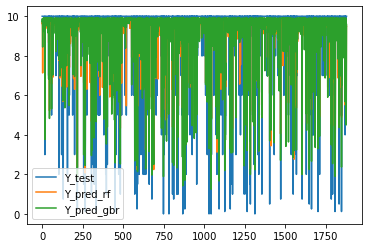

In [45]:
res.plot()

<AxesSubplot:>

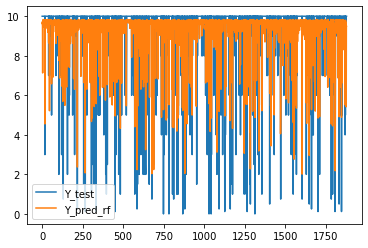

In [46]:
res[['Y_test', 'Y_pred_rf']].plot()

<AxesSubplot:>

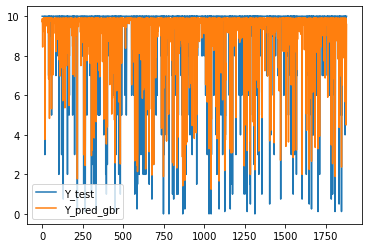

In [47]:
res[['Y_test', 'Y_pred_gbr']].plot()